things that could be wrong:
- chopping data into batches <- CHECKED. WORKS FINE
- reshapes for logits <- LOOKS STRANGE IN SOME PLACES
- loss function (implement by hand and compare)
- train longer
- sample from output probs <- DONE for sampling. looks better. needs to be implemented for loss calc in training

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from IPython.display import clear_output

In [ ]:
!wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

In [2]:
with open('t8.shakespeare.txt') as file:
    raw_lines = [line.replace('\r',' ') for line in file.readlines()]
    
raw_text = ' '.join(raw_lines[300:-300])

In [3]:
vocab = list(set(raw_text))
trans_dic = {vocab[i]: i for i in range(len(vocab))}
rev_trans_dic = {i: vocab[i] for i in range(len(vocab))}
raw_text_enc = [trans_dic[letter] for letter in raw_text]

define some parameters

In [4]:
text_size = len(raw_text_enc)
vocab_size = len(vocab)
num_neurons = 500
num_steps = 200
batch_size = 4000

function to generate batches of data

In [5]:
def gen_batch(raw_x, batch_size, num_steps):

    if batch_size % num_steps != 0:
        warnings.warn("Warning: batch size is not a multiple of num_steps.")    
    raw_y = raw_x[1:] + [raw_x[0]]    
    # partition raw data into batches and stack them vertically in a data matrix
    num_batch = len(raw_x) // batch_size
    data_x = np.zeros([num_batch, batch_size], dtype=np.int32)
    data_y = np.zeros([num_batch, batch_size], dtype=np.int32)    
    for i in range(num_batch):
        data_x[i] = raw_x[batch_size * i:batch_size * (i + 1)]
        data_y[i] = raw_y[batch_size * i:batch_size * (i + 1)]    
    # further divide batch partitions into num_steps for truncated backprop
    batch_lines = batch_size // num_steps
    for i in range(num_batch):
        x = np.zeros([batch_lines,num_steps],dtype=np.int32)
        y = np.zeros([batch_lines,num_steps],dtype=np.int32)
        for n in range(batch_lines):
            x[n,:] = data_x[i, n * num_steps:(n + 1) * num_steps]
            y[n,:] = data_y[i, n * num_steps:(n + 1) * num_steps]
        yield (x, y)

In [6]:
def gen_epochs(raw_data, num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(raw_data,batch_size,num_steps)

DEBUG: data into batches:

In [ ]:
batch_test = gen_batch(raw_text_enc, 200, 20)

In [ ]:
"".join([rev_trans_dic[i] for i in batch_test.next()[0].flatten().tolist()])

### define the graph

In [7]:
tf.reset_default_graph()

input layer:

In [8]:
x = tf.placeholder(tf.int64, [None, num_steps])
y = tf.placeholder(tf.int64, [None, num_steps])
init_state = tf.placeholder(tf.float32,[None, num_neurons])

#resulting tensor is of rank batch_size // num_steps x num_steps x vocab_size
x_one_hot = tf.one_hot(x, vocab_size)

hidden layer:

In [9]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_neurons)
rnn_output, final_state = tf.nn.dynamic_rnn(cell, x_one_hot, initial_state=init_state, dtype=tf.float32)

output layer:

In [10]:
with tf.variable_scope('softmax'):
    weight = tf.Variable(tf.truncated_normal([num_neurons, vocab_size], stddev=0.1))
    bias = tf.Variable(tf.constant(0.1, shape=[vocab_size]))

output = tf.reshape(rnn_output, [-1, num_neurons])
logits = tf.matmul(output, weight) + bias
pre_prediction = tf.nn.softmax(logits)
prediction = tf.reshape(pre_prediction, [-1, num_steps, vocab_size])

loss function:

In [11]:
target = tf.reshape(y,[-1])
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,target))
correct_prediction = tf.equal(tf.argmax(prediction, 2),y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

training:

In [13]:
optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
trainOp = optimizer.minimize(loss)

In [14]:
init_vars = tf.initialize_all_variables()
trainHist = []

sess = tf.Session()
sess.run(init_vars)

for idx, epoch in enumerate(gen_epochs(raw_text_enc[:],10,batch_size,num_steps)):
    training_state = np.zeros((batch_size // num_steps, num_neurons))
    for i, batch in enumerate(epoch):
        acc, lossVal, training_state, _,  x_one_h, weight_tmp, rnn_outp, outp, logits_tmp, pre_pred, pred = sess.run([accuracy, loss, final_state, trainOp, x_one_hot, weight, rnn_output, output, logits, pre_prediction, prediction], 
                                                                                  feed_dict={x: batch[0], y: batch[1],init_state: training_state})
        trainHist.append(lossVal)

        if i % 100 == 0:
            clear_output()
            print(idx, i, lossVal, acc)

(9, 1300, 1.9446044, 0.46024999)


DEBUG: shape messup with reshapes for logits?

In [ ]:
print("x_one_hot: ", x_one_h.shape)
print("rnn_output: ", rnn_outp.shape)
#print("output = tf.reshape(rnn_output, [-1, num_neurons])")
print("output: ", outp.shape)
print("weights: ", weight_tmp.shape)
print("logits: ", logits_tmp.shape)
#print("pre_prediction = tf.nn.softmax(logits)")
print("pre_prediction: ", pre_pred.shape)
#print("prediction = tf.reshape(pre_prediction, [-1, num_steps, vocab_size])")
print("prediction: ", pred.shape)

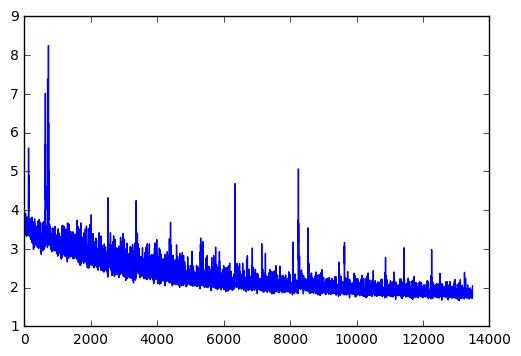

In [17]:
plt.plot(trainHist[400:])

forward-feed:

In [ ]:
prev = np.random.choice(vocab_size,num_steps).astype(np.float32).reshape(1,num_steps)
last_state = np.zeros((1, num_neurons),dtype=np.float32)

digital_shakespeare = []

def my_func(prob_array):
    choice_char = rev_trans_dic[np.random.choice(a = range(vocab_size), p = prob_array)]
    return choice_char

for i in range(10):
    pre_pred, last_state = sess.run([pre_prediction,final_state],feed_dict={x: prev, init_state: last_state})
    #prev = np.argmax(pred,axis=2)
    digital_shakespeare += "".join(np.apply_along_axis(my_func, 1, pre_pred).flatten().tolist())

In [ ]:
print("".join(digital_shakespeare))

In [ ]:
res = np.argmax(pred,axis=2)
res.flatten().shape

In [ ]:
plt.plot(trainHist)

# Hyperparams:

In [ ]:
grid = []
for learnRate in [0.0001,0.001,0.01,0.1]:

    optimizer = tf.train.AdamOptimizer(learning_rate=learnRate)
    trainOp = optimizer.minimize(loss)

    init_vars = tf.initialize_all_variables()
    trainHist = []
    with tf.Session() as sess:
        sess.run(init_vars)
        for epoch in gen_epochs(raw_text_enc[:],1,batch_size,num_steps):
            for i, batch in enumerate(epoch):
                lossVal, _ = sess.run([loss,trainOp],feed_dict={x: batch[0], y: batch[1]})
                trainHist.append(lossVal)

                if i % 100 == 0:
                    clear_output()
                    print(learnRate, i, lossVal)
    
    grid.append(trainHist)

In [ ]:
for i in range(4):
    plt.plot(grid[i])
    plt.show()